In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as tick
from itertools import product

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

TOP_N = 20

# Convert .csv datasets to DataFrames
data = pd.read_csv("Twitch_game_data.csv", sep=',')
monthly_df = pd.read_csv("Twitch_global_data.csv", sep=',')
genre_df = pd.read_csv("game_genres.csv", sep=',')

# Clean data

    # Remove " hours" from Hours_Streamed column
    # Convert Hours_Streamed column to int
data["Hours_Streamed"] = data["Hours_Streamed"].map(lambda x : x.rstrip(" hours"))
data["Hours_Streamed"] = pd.to_numeric(data["Hours_Streamed"])

    # Add game genres to each entry
data = pd.merge(data, genre_df, on="Game")

    # Aggregate Date
data["Date"] = data["Year"].map(str) + '-' + data['Month'].map(str)
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m').dt.strftime('%Y-%m')

    # Replace Unicode characters
print("Unicode characters found: ", data["Game"].str.extract(r'(<.*>)', expand=False).unique())
''' 
<U+00E9> - e
<U+00DB> - U
<U+2212> - -
<U+72FC> - 狼
<U+4EBA> - 人
<U+6BBA> - 殺
<U+014C> - O
<U+016B> - u
'''
data["Game"] = data["Game"].str.replace(r'<U\+00E9>','e', regex=True)
data["Game"] = data["Game"].str.replace(r'<U\+00DB>','U', regex=True)
data["Game"] = data["Game"].str.replace(r'<U\+2212>','-', regex=True)
data["Game"] = data["Game"].str.replace(r'<U\+72FC>','狼', regex=True)
data["Game"] = data["Game"].str.replace(r'<U\+4EBA>','人', regex=True)
data["Game"] = data["Game"].str.replace(r'<U\+6BBA>','殺', regex=True)
data["Game"] = data["Game"].str.replace(r'<U\+014C>','O', regex=True)
data["Game"] = data["Game"].str.replace(r'<U\+016B>','u', regex=True)

    # Remove ranks past TOP_N
data = data.loc[data['Rank'] <= TOP_N]

    # Reorder by time
data = data.sort_values(by=['Month', 'Year'], ignore_index=True)

    # Remove missing values
data.dropna(inplace=True)

data.head()

Unicode characters found:  [nan '<U+00E9>' '<U+00DB>' '<U+2212>' '<U+72FC><U+4EBA><U+6BBA>'
 '<U+014C>' '<U+016B>']


,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Genre
0,1,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69.29,"MOBA,Action"
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57.62,"FPS,Shooter,Action"
2,3,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104.26,"MOBA,Action,Strategy"
3,4,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169.29,"Card & Board Game,Strategy"
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14.03,"FPS,Shooter,Adventure Game,Action"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,6,Call of Duty: Warzone,12,2020,65844965,2460572,343398,7996,174916,88620,3311,26.76,"FPS,Shooter"
1392,14,VALORANT,12,2020,42375108,2174160,286887,4958,197181,57032,2926,19.49,"Shooter,FPS"
1393,11,Among Us,12,2020,50435363,898171,493501,3332,178817,67880,1208,56.15,"Strategy,Survival,Indie Game,Action,Stealth"
1394,12,FIFA 21,12,2020,43110526,902019,304406,3646,102912,58022,1214,47.79,"Sports Game,Simulation"


In [ ]:
top_games = data['Game'].unique()
years = data['Year'].unique()
months = data['Month'].unique()

# for game in top_games:
#     game_df = data[(data['Game'] == game)]

#     game_hours_watched = game_df['Hours_watched'].sum()
#     game_hours_streamed = game_df['Hours_Streamed'].sum()

#     print(game_hours_watched)
#     print(game_hours_streamed)


game_total_hours_df = data[['Game', 'Hours_watched', 'Hours_Streamed']]
game_total_hours_df = game_total_hours_df.groupby(['Game']).sum()

plt.figure(1)

plot = game_total_hours_df.plot.scatter(
        x='Hours_Streamed',
        y='Hours_watched',
        figsize=(12,7), 
        grid=True,
        title='Twitch Top 20 Games: Total Hours Steamed vs. Total Hours Watched (2016 - 2021)',
        xlabel="Hours Streamed",
        ylabel="Hours Watched"
    )

for game, pt in game_total_hours_df.iterrows():
        plot.annotate(game, (pt.at['Hours_Streamed'], pt.at['Hours_watched']))
    

## Bar Chart of Total Games per Genre

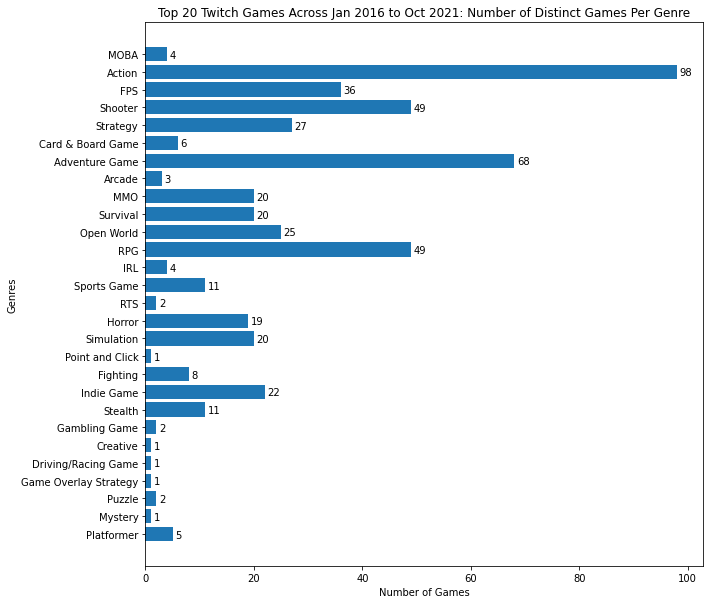

In [100]:
# Get unique games
g_data = data.drop_duplicates('Game')
genre_counts = {}
count = 0
for i, r in g_data.iterrows():
    genre = str(r['Genre']).split(",")
    for g in genre:
        if g not in genre_counts:
            genre_counts[g] = 1
        else:
            genre_counts[g] += 1

        count += 1

# Make bar chart
fig, ax = plt.subplots()
genre_y = np.arange(len(genre_counts.keys()))
genre_labels = list(genre_counts.keys())
ax.barh(genre_y, genre_counts.values(), align='center')
ax.set_yticks(genre_y)
ax.set_yticklabels(genre_labels)
ax.invert_yaxis()
ax.set_xlabel('Number of Games')
ax.set_ylabel('Genres')
ax.set_title('Top 20 Twitch Games Across Jan 2016 to Oct 2021: Number of Distinct Games Per Genre')
fig.set_size_inches(10, 10)

for i, v in enumerate(genre_counts.values()):
    ax.text(v + .5, i + .2, str(v))

plt.show()


## Bar Chart of Total Average Viewership vs Genre Over All Time

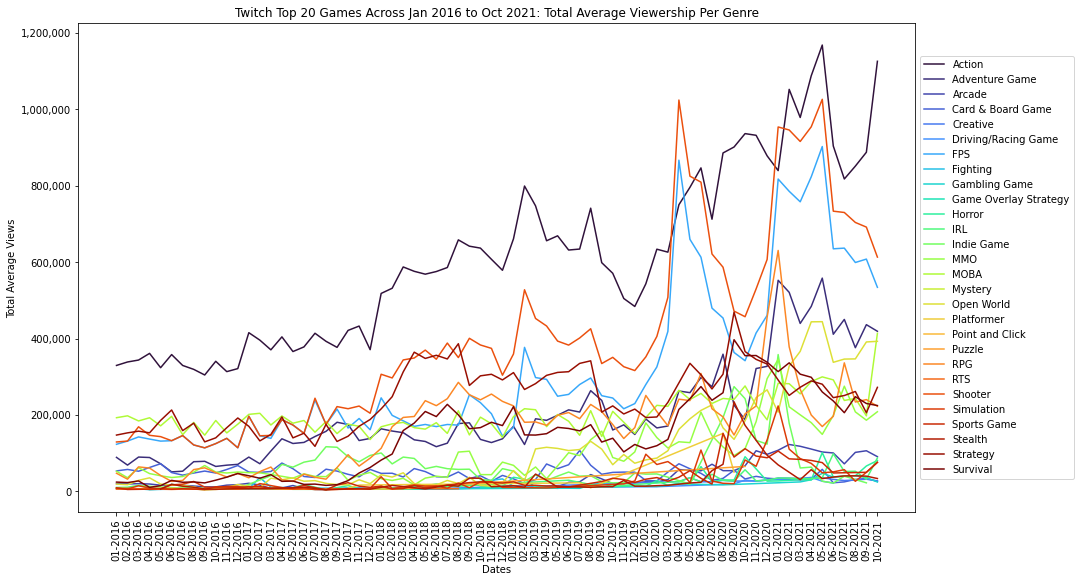

In [128]:
genres = list(genre_counts.keys())
genres.sort()
# dates = list(data.groupby(['Month', 'Year']).groups)
# view_gen = {}
# for key in dates:
#     dic = {g: 0 for g in genres}
#     view_gen[key] = dic
# for i, r in t_data.iterrows():
#     genre = str(r['Genre']).split(",")
#     date = (int(r['Month']), int(r['Year']))
#     views = r['Avg_viewers']
#     for g in genre:
#         view_gen[date][g] += views
#         # print("Date: " + str(date) + " Genre: " + str(g) + " Total: " + str(view_gen[date][g]) + " Avg_viewers: " + str(views))

plt.figure(figsize=(15, 9))
colors = cm.turbo(np.linspace(0, 1, len(genres)))

for c, genre in zip(colors, genres):
    view_gen = data[data['Genre'].str.contains(genre)][['Month', 'Year', 'Avg_viewers']].groupby(['Month', 'Year'], as_index=False).sum()
    view_gen.sort_values(['Year', 'Month'], inplace=True)

    view_gen['date'] = view_gen['Month'].map(str)+ '-' + view_gen['Year'].map(str)
    view_gen['date'] = pd.to_datetime(view_gen['date'], format='%m-%Y').dt.strftime('%m-%Y')
    plt.plot_date(
        view_gen['date'],
        view_gen['Avg_viewers'],
        fmt='-',
        label=genre,
        color=c)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Twitch Top 20 Games Across Jan 2016 to Oct 2021: Total Average Viewership Per Genre')
plt.ylabel('Total Average Views')
plt.xlabel('Dates')
plt.xticks(rotation=90)
ax = plt.gca()
ax.get_yaxis().set_major_formatter(
    tick.FuncFormatter(lambda x, p: format(int(x), ',')))
    
plt.show()


## Average Stream Time Per Genre

Alex

In [ ]:
top_5_genres = ['Action', 'Adventure Game', 'RPG', 'Shooter', 'FPS']
plt.figure(figsize=(25,10))

for genre in top_5_genres:
    genre_df = data[data['Genre'].str.contains(genre)][['Month', 'Year', 'Hours_Streamed']].groupby(['Month', 'Year'], as_index=False).sum()
    genre_df.sort_values(['Year', 'Month'], inplace=True)

    genre_df['date'] = genre_df['Month'].map(str)+ '-' +genre_df['Year'].map(str)
    genre_df['date'] = pd.to_datetime(genre_df['date'], format='%m-%Y').dt.strftime('%m-%Y')
    plt.plot_date(
        genre_df['date'],
        genre_df['Hours_Streamed'],
        fmt='-',
        label=genre)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation = 90)
plt.title("Total Monthly Stream Hours for Twitch Categories ({} to {})".format(genre_df.Year.min(), genre_df.Year.max()))
plt.xlabel("Date (Month - Year)")
plt.ylabel("Efficiency")
plt.grid()

## Average Viewers Per Streamer by Genre

Brian

In [ ]:
genres_uniq = np.unique(','.join(data["Genre"]).split(','))
print(np.sort(genres_uniq))

# games_uniq = np.flip(data["Game"].unique())
# x_stack = np.arange(2016, 2021, 1/12)
# y_stack = {}

# for game in games_uniq:
#     y_stack[game] = []

# for year in range(2016, 2021):
#     for month in range(1,13):
#         month_20 = data.loc[(data["Month"] == month) & (data["Year"] == year)]
#         hours_watched_by_month = monthly_df.loc[(monthly_df["Month"] == month) & (monthly_df["year"] == year)]["Hours_watched"].values[0]

#         for game in games_uniq:
#             if game in month_20["Game"].values:
#                 y_stack[game].append(month_20.loc[month_20["Game"] == game]["Hours_watched"].values[0] / hours_watched_by_month * 100)
#             else:
#                 y_stack[game].append(0)

# y_stack = np.array([y_stack[i] for i in y_stack.keys()])
# print(len(games_uniq))

# plt.stackplot(x_stack, y_stack, labels=games_uniq)

plt.figure(figsize=(25, 10))
for genre in genres_uniq:
    data_by_genre = data.loc[data["Genre"].str.contains(genre)]
    grouped = data_by_genre.groupby(["Date"])["Avg_viewer_ratio"].mean().reset_index()
    
    plt.plot_date(
        grouped['Date'],
        grouped['Avg_viewer_ratio'],
        fmt='-',
        label=genre)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.title("Average Viewers per Streamer by Genre")
plt.ylabel("Average Viewers")
plt.xlabel("Time")
plt.grid()

## Average Genre Rank Over Time

Brian

In [ ]:
# Genre Rank over time
plt.figure(figsize=(25, 10))
for genre in genres_uniq:
    data_by_genre = data.loc[data["Genre"].str.contains(genre)]
    grouped = data_by_genre.groupby(["Date"])["Rank"].mean().reset_index()

    plt.plot_date(
        grouped['Date'],
        grouped['Rank'],
        fmt='-',
        label=genre)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.yticks(np.arange(1, 21, 1.0))
plt.title("Average Genre Rank Over Time")
plt.ylabel("Rank")
plt.ylim([1, 20])
plt.xlabel("Time")
plt.gca().invert_yaxis()
plt.grid()

## Number of Occurrences of a Genre in the Top 20 Over All Time

Brian

In [ ]:
# Genre Occurrences over time
plt.figure(figsize=(25, 10))
for genre in genres_uniq:
    data_by_genre = data.loc[data["Genre"].str.contains(genre)]
    grouped = data_by_genre.groupby(["Date"])["Rank"].count().reset_index()

    plt.plot_date(
        grouped['Date'],
        grouped['Rank'],
        fmt='-',
        label=genre)
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.yticks(np.arange(1, 21, 1.0))
plt.title("# of Occurrences of a Genre in the Top 20 Over Time")
plt.ylabel("# of Occurrences in Top 20")
plt.ylim([0, 20])
plt.xlabel("Time")
plt.grid()
    

## Twitch Top 20 Games: Total Hours Streamed vs Total Hours Watched (2016-2021)

Brian

In [ ]:
top_games = data['Game'].unique()
years = data['Year'].unique()
months = data['Month'].unique()

# for game in top_games:
#     game_df = data[(data['Game'] == game)]

#     game_hours_watched = game_df['Hours_watched'].sum()
#     game_hours_streamed = game_df['Hours_Streamed'].sum()

#     print(game_hours_watched)
#     print(game_hours_streamed)


game_total_hours_df = data[['Game', 'Hours_watched', 'Hours_Streamed']]
game_total_hours_df = game_total_hours_df.groupby(['Game']).sum()

plt.figure(1)

plot = game_total_hours_df.plot.scatter(
        x='Hours_Streamed',
        y='Hours_watched',
        figsize=(12,7), 
        grid=True,
        title='Twitch Top 20 Games: Total Hours Steamed vs. Total Hours Watched (2016 - 2021)',
        xlabel="Hours Streamed",
        ylabel="Hours Watched"
    )

for game, pt in game_total_hours_df.iterrows():
        plot.annotate(game, (pt.at['Hours_Streamed'], pt.at['Hours_watched']))
    